# Clustering Analysis
This notebook is to execute the process from data wrangling to running of unsupervised machine learning to derive groupings and discover unknown connections among the data.

In [1]:
import pandas as pd
import datetime
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell #allow multiple outputs from same box
InteractiveShell.ast_node_interactivity = "all"
from gmplot import *

# Data Wrangling

In [2]:
#import bike data. data are stored in files by month. Import March data for both NYC and Jersey City.
Allbikedata = ['201803-citibike-tripdata.csv','JC-201803-citibike-tripdata.csv']

path = 'C:/Users/Charles/Desktop/Data Science/Capstone Project 1/'
NYCBike_Data = {}
merged_file = {}
for month in Allbikedata :
    if month =='201803-citibike-tripdata.csv':
        NYCBike_Data = pd.read_csv('C:/Users/Charles/Desktop/Data Science/Capstone Project 1/201803-citibike-tripdata.csv.zip')
    else :
        NYCBike_Data2 = pd.read_csv(path + month +'.zip') 
        NYCBike_Data = pd.concat([NYCBike_Data, NYCBike_Data2], axis = 0)

#import weather data        
NYC_Weather = {}
NYC_Weather = pd.read_csv(r'''C:\Users\Charles\Desktop\Data Science\Capstone Project 1\NYC Weather.csv''',dtype={33: str, 43: str, 89: str})

#convert string data into datetime data
NYC_Weather['Clean_Date']=pd.to_datetime(NYC_Weather.DATE, format = "%Y-%m-%dT%H:%M:%S.%f")
NYCBike_Data['Clean_Date']=pd.to_datetime(NYCBike_Data.starttime, format = "%Y-%m-%d %H:%M:%S.%f")

#get rid of minute and second data
NYC_Weather['Clean_Date']=NYC_Weather['Clean_Date'].apply(lambda dt: dt.replace(minute=0, second=0, microsecond=0)+ datetime.timedelta(hours=1))
NYCBike_Data['Clean_Date']=NYCBike_Data['Clean_Date'].apply(lambda dt: dt.replace(minute=0, second=0,microsecond=0)+ datetime.timedelta(hours=1))



In [3]:
#remove unwanted columns and filter to get rid of subtotal rows
NYC_Weather=NYC_Weather[['Clean_Date', 'REPORT_TYPE','HourlyDewPointTemperature','HourlyDryBulbTemperature','HourlyPrecipitation','HourlyRelativeHumidity']]
NYC_Weather=NYC_Weather.loc[NYC_Weather['REPORT_TYPE'].isin(['FM-15','FM-16'])]
#merge the two files bike and weather
merged_file = pd.merge(NYC_Weather, NYCBike_Data, on = 'Clean_Date')

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#merged_file

In [5]:
#check for blank cells
print(merged_file.isnull().any())

Clean_Date                   False
REPORT_TYPE                  False
HourlyDewPointTemperature    False
HourlyDryBulbTemperature     False
HourlyPrecipitation           True
HourlyRelativeHumidity       False
tripduration                 False
starttime                    False
stoptime                     False
start station id             False
start station name           False
start station latitude       False
start station longitude      False
end station id               False
end station name             False
end station latitude         False
end station longitude        False
bikeid                       False
usertype                     False
birth year                   False
gender                       False
dtype: bool


The only metric with blank cells is Hourly Precipitation. Given that the difference shouldn't be too big from one hour to another, bfill is used to fill the blanks.

In [6]:
#fill up blank cells
merged_file[merged_file[['HourlyPrecipitation']]=='']=np.nan
merged_file_cleaned=merged_file.fillna(method = 'bfill')

Distance between two stations is not provided so we have to calculate that ourselves. The two main methods is looking at distance from a geometric perspective and from a street distance prespective. 

Street Distance is a more realistic measure but it will require paid subscription to Google so as a result we are using haversine to determine geometric distance. 

In [7]:
merged_file_cleaned['distance']=np.nan

In [8]:
def haversine_np( lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6372.8* c
    return km
merged_file_cleaned['distance'] = haversine_np(merged_file_cleaned['start station latitude'],merged_file_cleaned['start station longitude'],merged_file_cleaned['end station latitude'],merged_file_cleaned['end station longitude'])

In [9]:
#see how many unique stations we are working with
NYCBike_Data['start station name'].nunique()

819

As part of our analysis, we want to see if day of week and time of a day have any predictive attributes. Here we split out the data into Weekend/Weekdays, and Morning/Afternoon/Night

In [10]:
# Morning vs Afternoon
merged_file_cleaned[['h']] = pd.DataFrame([(x.hour) for x in merged_file_cleaned['Clean_Date']])
merged_file_cleaned[['Day_Of_Week']] = pd.DataFrame([(x.weekday()) for x in merged_file_cleaned['Clean_Date']])
merged_file_cleaned[['Day_Of_Month']] = pd.DataFrame([(x.day) for x in merged_file_cleaned['Clean_Date']])
merged_file_cleaned.loc[(merged_file_cleaned.h < 12) & (merged_file_cleaned.h >= 5), 'Day_Segment'] = 'Morning' 
merged_file_cleaned.loc[(merged_file_cleaned.h < 22) & (merged_file_cleaned.h >= 12), 'Day_Segment'] = 'Afternoon'
merged_file_cleaned.loc[(merged_file_cleaned.h < 5) | (merged_file_cleaned.h >= 22), 'Day_Segment'] = 'Night' 

In [11]:
def weekend_vs_weekday(day):
    if(day < 6):
        return 'Weekday'
    else:
        return 'Weekend'
merged_file_cleaned['Weekend_Vs_Weekday'] = merged_file_cleaned['Day_Of_Week'].apply(weekend_vs_weekday)

In [12]:
#to see what the data is looking like
merged_file_cleaned.head(1)

,Clean_Date,REPORT_TYPE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,distance,h,Day_Of_Week,Day_Of_Month,Day_Segment,Weekend_Vs_Weekday
0,2018-03-01 01:00:00,FM-15,36.0,55,0.00,49.0,364,2018-03-01 00:08:55.0290,2018-03-01 00:14:59.5770,82,St James Pl & Pearl St,40.711174,-74.000165,312,Allen St & Stanton St,40.722055,-73.989111,28503,Subscriber,1993,1,1.527469,1,3,1,Night,Weekday


In [13]:
merged_file_cleaned.shape

(1142708, 27)

We assume anything with distance of over 10km to be outlier. There are 501 of these trips relative to over 900,000 trips in the overall data set. These outliers are removed.

In [14]:
pd.set_option('float_format', '{:f}'.format)
merged_file_cleaned.describe()

,HourlyDewPointTemperature,HourlyRelativeHumidity,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,distance,h,Day_Of_Week,Day_Of_Month
count,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000,1142708.000000
mean,25.622861,54.694149,880.130320,1527.545488,40.737213,-73.984049,1516.676090,40.736875,-73.984343,26485.363934,1978.065816,1.154348,1.635591,14.389937,2.939821,17.198369
std,11.565217,20.330339,26770.803896,1418.082785,0.032670,0.019829,1415.911753,0.032368,0.019861,5934.713756,12.055224,0.500908,1.292634,4.980986,1.875738,9.348586
min,-11.000000,15.000000,61.000000,72.000000,40.646538,-74.096937,72.000000,40.646538,-74.096937,14529.000000,1885.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,18.000000,40.000000,318.000000,379.000000,40.718939,-73.995168,377.000000,40.718822,-73.995960,20618.000000,1969.000000,1.000000,0.781884,10.000000,1.000000,9.000000
50%,23.000000,52.000000,522.000000,501.000000,40.738177,-73.986317,499.000000,40.737604,-73.986831,28462.000000,1980.000000,1.000000,1.264110,15.000000,3.000000,17.000000
75%,32.000000,68.000000,886.000000,3211.000000,40.756405,-73.974931,3207.000000,40.755942,-73.975361,31453.000000,1988.000000,1.000000,2.078010,18.000000,4.000000,26.000000
max,53.000000,97.000000,15020934.000000,3674.000000,45.506264,-73.568906,3674.000000,45.506264,-73.568906,33551.000000,2002.000000,2.000000,14.975722,23.000000,6.000000,31.000000


In [15]:
merged_file_cleaned['distance'].loc[merged_file_cleaned['distance']>10].count()

501

In [16]:
#store outliers
outliers = merged_file_cleaned.loc[merged_file_cleaned['distance']>10]

In [17]:
#Removes Outliers
merged_file_cleaned=merged_file_cleaned.drop(outliers.index.values)

In [18]:
#Confirm deletion of outliers
merged_file_cleaned.distance.loc[merged_file_cleaned['distance']>10].count()

0

# Corr Matrix

we want to check to see if there are any high correlation variables we should take a look at. The ones seen in the matrix are all expected

In [19]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr = merged_file_cleaned.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify()) 

,HourlyDewPointTemperature,HourlyRelativeHumidity,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,distance,h,Day_Of_Week,Day_Of_Month
HourlyDewPointTemperature,1,0.83,0.00053,-0.0096,0.0063,-0.011,-0.0089,0.0082,-0.0091,0.0018,0.0058,0.0019,0.0056,-0.015,-0.04,0.15
HourlyRelativeHumidity,0.83,1,-0.00082,-0.012,0.0047,-0.0061,-0.014,0.0049,-0.0058,0.0044,0.016,0.018,-0.016,-0.11,-0.17,-0.016
tripduration,0.00053,-0.00082,1,0.0043,-0.00034,0.0046,0.0053,-0.0027,0.0039,-0.0024,-0.0028,-0.0061,0.028,0.0018,0.0046,0.0027
start station id,-0.0096,-0.012,0.0043,1,0.14,0.36,0.4,0.1,0.29,-0.0048,-0.0064,0.00034,0.024,-0.017,0.03,0.0098
start station latitude,0.0063,0.0047,-0.00034,0.14,1,0.27,0.087,0.89,0.22,-0.014,-0.056,-0.042,0.055,-0.014,-0.019,0.0066
start station longitude,-0.011,-0.0061,0.0046,0.36,0.27,1,0.28,0.23,0.77,-0.039,0.046,0.0072,0.042,-0.032,0.031,-0.0011
end station id,-0.0089,-0.014,0.0053,0.4,0.087,0.28,1,0.12,0.36,-0.0038,0.0024,0.0012,0.00078,0.019,0.03,0.0099
end station latitude,0.0082,0.0049,-0.0027,0.1,0.89,0.23,0.12,1,0.28,-0.011,-0.056,-0.04,0.041,-0.011,-0.021,0.0072
end station longitude,-0.0091,-0.0058,0.0039,0.29,0.22,0.77,0.36,0.28,1,-0.036,0.043,0.0064,0.022,0.022,0.025,0.0005
bikeid,0.0018,0.0044,-0.0024,-0.0048,-0.014,-0.039,-0.0038,-0.011,-0.036,1,0.0092,-0.025,0.045,-0.0031,0.0091,0.0076


# Machine Learning Data Feed

Here we convert the bike data into format compatible with the sklearn package. Primary measurement will be distance, split out into Weekend/Weekday, Morning/Afternoon/Night, and day of Month 

In [20]:
#each individual starting station per row. 
#aggregate by mean distance between starting and ending station. 
pivot_start_station_WvW = merged_file_cleaned.pivot_table(index='start station name',aggfunc='mean',columns = 'Weekend_Vs_Weekday',values='distance')
pivot_start_station_DOM = merged_file_cleaned.pivot_table(index='start station name',aggfunc='mean',columns = 'Day_Of_Month',values='distance')
pivot_start_station_NAM = merged_file_cleaned.pivot_table(index='start station name',aggfunc='mean',columns = 'Day_Segment',values='distance')

start_station_merge = pivot_start_station_WvW.merge(pivot_start_station_NAM,left_index=True, right_index=True)
start_station_merge = start_station_merge.merge(pivot_start_station_DOM,left_index=True, right_index=True)

#count instead of mean
pivot_start_station_WvW_c = merged_file_cleaned.pivot_table(index='start station name',aggfunc='count',columns = 'Weekend_Vs_Weekday',values='distance')
pivot_start_station_DOM_c = merged_file_cleaned.pivot_table(index='start station name',aggfunc='count',columns = 'Day_Of_Month',values='distance')
pivot_start_station_NAM_c = merged_file_cleaned.pivot_table(index='start station name',aggfunc='count',columns = 'Day_Segment',values='distance')

start_station_merge_c = pivot_start_station_WvW_c.merge(pivot_start_station_NAM_c,left_index=True, right_index=True)
start_station_merge_c = start_station_merge_c.merge(pivot_start_station_DOM_c,left_index=True, right_index=True)

final_merge = start_station_merge.merge(start_station_merge_c,left_index=True, right_index=True)
final_merge = final_merge.fillna(0)

basic data exploration of the new pivoted data

In [21]:
pivot_start_station_WvW.shape

(819, 2)

In [22]:
#Pivot Table merged mean
final_merge.head()

,Weekday_x,Weekend_x,Afternoon_x,Morning_x,Night_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,Weekday_y,Weekend_y,Afternoon_y,Morning_y,Night_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y
start station name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1 Ave & E 110 St,1.718788,1.700704,1.465301,2.041189,1.599372,2.660581,2.081245,0.946694,1.553139,2.272631,2.229693,1.943616,2.187876,1.711818,1.268549,1.314499,1.748369,1.487175,1.636080,1.782087,1.796885,4.003246,1.911329,1.379410,1.769628,2.688320,1.465043,1.659242,1.391406,2.150731,1.368023,1.657689,1.562046,1.631465,1.181888,1.189994,532.000000,47.000000,298.000000,245.000000,36.000000,19.000000,21.000000,14.000000,8.000000,23.000000,24.000000,18.000000,14.000000,26.000000,17.000000,17.000000,20.000000,22.000000,18.000000,21.000000,16.000000,7.000000,9.000000,23.000000,19.000000,4.000000,13.000000,20.000000,13.000000,13.000000,12.000000,20.000000,24.000000,48.000000,43.000000,13.000000
1 Ave & E 16 St,1.377518,1.386913,1.308034,1.582250,1.055999,1.461239,1.203083,1.324631,1.453308,1.242648,1.436360,1.155809,1.333005,1.401106,1.422206,1.509895,1.320085,1.278896,1.328880,1.422068,1.356690,1.513701,1.337813,1.439195,1.435690,1.163417,1.341998,1.441401,1.405057,1.283021,1.360166,1.546942,1.413829,1.405479,1.286362,1.549648,4409.000000,542.000000,2655.000000,1763.000000,533.000000,183.000000,132.000000,162.000000,123.000000,127.000000,177.000000,120.000000,182.000000,192.000000,132.000000,126.000000,116.000000,171.000000,193.000000,158.000000,157.000000,162.000000,123.000000,132.000000,157.000000,57.000000,112.000000,186.000000,168.000000,168.000000,140.000000,144.000000,185.000000,310.000000,301.000000,155.000000
1 Ave & E 18 St,1.434815,1.324481,1.355304,1.557268,1.169609,1.404697,1.119422,1.546569,1.191275,1.351503,1.561546,1.293227,1.430169,1.541190,1.349570,1.334437,1.511378,1.334198,1.380318,1.451841,1.353561,1.456537,1.514578,1.654065,1.427030,1.561996,1.544298,1.223485,1.647927,1.347905,1.402093,1.397883,1.403960,1.325095,1.481350,1.564805,3022.000000,339.000000,1818.000000,1332.000000,211.000000,150.000000,86.000000,126.000000,98.000000,82.000000,126.000000,89.000000,84.000000,131.000000,116.000000,77.000000,94.000000,99.000000,130.000000,93.000000,109.000000,113.000000,56.000000,94.000000,95.000000,49.000000,87.000000,108.000000,126.000000,105.000000,80.000000,106.000000,122.000000,210.000000,204.000000,116.000000
1 Ave & E 30 St,1.716374,1.655901,1.712386,1.761793,1.387940,1.745779,1.448813,1.998376,1.657382,1.824317,1.784822,1.264163,1.641913,1.660925,1.784376,1.523107,1.641489,1.634680,1.824728,1.761782,1.555733,1.671434,1.757052,1.656970,1.755976,1.387673,1.992633,1.748661,1.485343,1.641993,1.723246,1.861419,1.610615,1.755586,1.794307,1.939266,3133.000000,196.000000,2029.000000,1132.000000,168.000000,165.000000,84.000000,61.000000,49.000000,117.000000,130.000000,75.000000,135.000000,126.000000,56.000000,41.000000,123.000000,109.000000,157.000000,147.000000,115.000000,62.000000,54.000000,144.000000,125.000000,38.000000,93.000000,123.000000,52.000000,51.000000,143.000000,138.000000,143.000000,239.000000,184.000000,50.000000
1 Ave & E 44 St,2.023485,1.986871,2.090722,1.733576,2.327408,2.151426,2.352789,1.792484,1.981831,1.800050,2.295415,1.282999,2.067719,1.937532,2.126737,1.839179,1.957983,1.760298,1.871570,2.080955,2.042326,2.187668,2.283472,1.924551,1.948083,1.478805,2.104475,1.973547,1.903732,1.919794,1.980761,2.045529,2.194007,2.215111,1.967924,2.108306,1989.000000,126.000000,1526.000000,482.000000,107.000000,90.000000,28.000000,34.000000,28.000000,85.000000,101.000000,26.000000,81.000000,83.000000,36.000000,34.000000,92.000000,70.000000,94.000000,100.000000,87.000000,30.000000,26.000000,84.000000,76.000000,17.000000,81.000000,80.000000

In [23]:
final_merge.describe()

,Weekday_x,Weekend_x,Afternoon_x,Morning_x,Night_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,Weekday_y,Weekend_y,Afternoon_y,Morning_y,Night_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,1.664832,1.592925,1.600554,1.752661,1.476287,1.744280,1.272242,1.551143,1.545775,1.659270,1.658004,1.396784,1.527703,1.620316,1.522931,1.556991,1.644310,1.469492,1.553979,1.609300,1.573901,1.573985,1.524790,1.651827,1.593208,1.275032,1.530141,1.632118,1.675747,1.564694,1.680326,1.665711,1.662060,1.653444,1.612610,1.686586,1259.000000,135.636142,881.395604,401.505495,111.735043,59.597070,25.388278,35.311355,31.487179,45.743590,56.499389,21.476190,44.533578,49.013431,31.543346,34.421245,48.689866,44.014652,55.792430,48.930403,43.450549,34.266178,31.344322,48.758242,44.279609,12.765568,35.363858,47.757021,42.737485,37.632479,50.067155,51.457875,57.067155,101.660562,71.848596,51.737485
std,0.464993,0.457438,0.429325,0.602878,0.564931,0.625139,0.891111,0.574671,0.589641,0.637854,0.608568,0.886090,0.691579,0.662060,0.618785,0.577887,0.640412,0.708775,0.644769,0.587799,0.638911,0.608050,0.605659,0.597348,0.615937,1.028075,0.731318,0.616915,0.607609,0.614839,0.630288,0.617703,0.589479,0.643453,0.643007,0.621778,1291.834509,126.169994,927.386436,437.463318,128.719666,63.824647,28.389591,34.633456,30.441828,50.573365,61.504276,22.770576,50.731324,52.607636,30.925955,32.773612,53.386550,48.154750,61.134873,53.933685,47.975095,33.579450,29.474387,53.152111,49.743437,17.633632,42.297173,52.092975,41.121303,35.847756,54.098020,57.098436,61.674428,111.053411,73.049161,53.274702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.417547,1.355314,1.356967,1.407447,1.169260,1.428336,0.823437,1.262019,1.246060,1.325723,1.343515,0.922296,1.189075,1.284456,1.226009,1.292054,1.339469,1.121849,1.233105,1.342369,1.256737,1.302256,1.236865,1.355379,1.305881,0.658936,1.210272,1.325613,1.406278,1.259916,1.348576,1.345276,1.367491,1.328377,1.310478,1.412795,325.000000,41.000000,213.000000,100.000000,28.500000,14.000000,5.500000,10.000000,9.000000,10.000000,13.500000,5.000000,8.000000,11.000000,9.000000,10.000000,11.000000,10.000000,13.000000,12.000000,10.000000,10.000000,10.000000,11.000000,10.000000,2.000000,6.000000,12.000000,13.500000,11.000000,12.000000,12.000000,14.000000,24.000000,18.000000,16.000000
50%,1.602984,1.558474,1.552866,1.679318,1.460382,1.689471,1.196207,1.530042,1.5116

# Training and Test Data Set Split

this is not necessary for unsupervised learning but has been done for practice

In [24]:
X_train_nonNorm, X_test = train_test_split(final_merge, test_size = 0.2, random_state = 20)

# Normalize Data
Normalize the data so that the mean is based on 0

In [25]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train_nonNorm)
X_train=scaler.transform(X_train_nonNorm)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

# PCA Component Choice

we want to reduce the components via using PCA

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'explained variance')

Text(0.5,0,'# components')

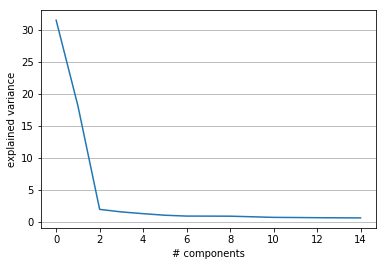

In [26]:
#x_cols = X_train
pca = PCA(n_components=15)
pca.fit(X_train)
pca_var=pca.explained_variance_
plt.plot(pca_var)
plt.ylabel('explained variance')
plt.xlabel('# components')
plt.gca().yaxis.grid() 
plt.show()

### Elbow is at K  = 2. We will be using 2 features.

# Determine Number of Clusters for K-Mean

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

array([1, 0, 1, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2,
       0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 0,
       0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2,
       0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0,
       0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2,
       0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1,
       2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 1, 1, 1, 0, 0, 1, 2,
       2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 0, 1, 2, 1, 2, 2, 0,
       2, 0, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 1, 2, 2, 0, 2, 1, 1, 0,
       0, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0,
       1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0,
       1, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2,

array([3, 0, 3, 0, 1, 0, 2, 1, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 3, 3, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 1, 0, 1, 2,
       0, 0, 1, 1, 1, 0, 2, 3, 1, 2, 0, 2, 3, 1, 1, 1, 0, 1, 1, 0, 2, 0,
       0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 0, 3, 3, 2, 2, 1, 3, 0,
       1, 1, 0, 0, 0, 0, 2, 0, 1, 3, 0, 1, 1, 0, 2, 3, 2, 2, 3, 1, 2, 2,
       0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 2, 0, 3, 0, 1, 0, 0, 0, 3, 1, 2, 1, 3, 2, 1, 2, 1,
       0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 3, 1, 2, 1, 3, 1, 3,
       1, 0, 0, 3, 2, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 3, 3, 3, 0, 0, 2, 2,
       1, 3, 2, 2, 0, 2, 1, 1, 1, 3, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0,
       1, 0, 1, 2, 3, 3, 1, 1, 0, 0, 1, 2, 0, 0, 3, 2, 1, 0, 1, 2, 2, 0,
       0, 0, 1, 2, 1, 1, 3, 0, 2, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       3, 2, 2, 1, 1, 2, 3, 1, 0, 2, 0, 2, 1, 2, 1, 0, 3, 2, 0, 1, 2, 0,
       3, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 3, 2,

array([2, 4, 2, 4, 1, 4, 3, 1, 2, 1, 1, 4, 4, 1, 4, 2, 4, 4, 4, 4, 4, 4,
       0, 3, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 0, 4, 1, 4, 4, 3,
       4, 0, 1, 1, 1, 0, 3, 2, 1, 3, 0, 3, 2, 1, 1, 1, 4, 1, 4, 4, 3, 0,
       4, 3, 4, 0, 3, 3, 4, 3, 3, 1, 4, 1, 1, 1, 4, 2, 2, 3, 4, 1, 2, 0,
       1, 4, 4, 4, 4, 4, 3, 4, 1, 2, 4, 1, 4, 0, 3, 2, 3, 3, 2, 1, 3, 3,
       4, 4, 4, 0, 0, 4, 4, 3, 4, 0, 2, 1, 4, 4, 4, 2, 4, 4, 1, 0, 1, 4,
       4, 4, 4, 4, 1, 3, 4, 2, 4, 1, 4, 4, 4, 2, 1, 3, 1, 2, 3, 1, 3, 1,
       4, 0, 4, 3, 4, 4, 4, 3, 3, 0, 4, 1, 4, 1, 1, 2, 1, 3, 4, 2, 1, 2,
       3, 4, 4, 2, 0, 1, 1, 4, 4, 4, 2, 1, 4, 1, 1, 2, 2, 2, 4, 0, 3, 4,
       4, 2, 3, 3, 4, 3, 4, 4, 1, 2, 0, 4, 4, 1, 4, 4, 3, 4, 3, 3, 3, 4,
       1, 4, 1, 3, 2, 2, 4, 4, 4, 4, 1, 3, 4, 0, 2, 3, 1, 4, 1, 3, 3, 4,
       0, 4, 4, 3, 1, 1, 2, 0, 3, 4, 3, 0, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4,
       2, 4, 3, 4, 1, 3, 2, 4, 4, 3, 4, 3, 1, 3, 1, 0, 2, 3, 0, 1, 3, 0,
       2, 1, 1, 4, 1, 4, 1, 4, 1, 1, 3, 4, 0, 2, 3,

array([1, 5, 3, 5, 0, 5, 1, 0, 3, 0, 0, 5, 5, 0, 5, 1, 5, 5, 5, 5, 5, 5,
       2, 4, 1, 1, 1, 5, 5, 5, 5, 5, 5, 4, 1, 5, 5, 5, 2, 5, 0, 5, 5, 4,
       5, 2, 0, 0, 0, 2, 1, 1, 0, 4, 2, 4, 1, 0, 0, 0, 5, 0, 5, 5, 4, 2,
       5, 4, 5, 2, 4, 4, 5, 4, 4, 0, 5, 0, 0, 0, 5, 1, 1, 1, 5, 0, 1, 2,
       0, 5, 5, 5, 5, 5, 4, 5, 0, 1, 5, 0, 5, 2, 1, 1, 4, 4, 1, 0, 1, 4,
       5, 0, 5, 2, 2, 5, 5, 1, 5, 2, 1, 0, 5, 5, 5, 3, 5, 5, 0, 2, 0, 5,
       5, 5, 5, 5, 0, 4, 5, 1, 5, 0, 5, 5, 5, 1, 0, 4, 0, 3, 1, 0, 1, 0,
       5, 2, 5, 4, 5, 5, 5, 4, 1, 2, 5, 0, 5, 0, 0, 1, 0, 4, 5, 1, 0, 1,
       4, 5, 5, 1, 2, 0, 0, 5, 5, 5, 1, 0, 5, 0, 0, 1, 1, 1, 5, 2, 4, 4,
       5, 3, 4, 4, 5, 4, 5, 5, 0, 1, 2, 5, 5, 0, 5, 5, 4, 5, 1, 4, 4, 5,
       0, 5, 0, 4, 3, 1, 5, 5, 5, 5, 0, 4, 5, 2, 1, 4, 0, 5, 0, 1, 4, 5,
       2, 5, 5, 4, 4, 0, 1, 2, 4, 5, 4, 2, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5,
       1, 4, 4, 5, 0, 4, 3, 5, 5, 4, 5, 1, 0, 4, 0, 2, 3, 4, 2, 0, 4, 2,
       1, 0, 0, 5, 0, 5, 0, 5, 0, 0, 4, 5, 2, 1, 4,

array([0, 3, 0, 3, 1, 3, 0, 2, 4, 1, 1, 3, 1, 2, 1, 0, 3, 3, 3, 3, 3, 3,
       3, 6, 0, 0, 0, 1, 3, 3, 3, 3, 3, 6, 0, 3, 3, 3, 5, 3, 2, 3, 1, 6,
       3, 5, 2, 1, 1, 5, 6, 0, 1, 6, 5, 6, 0, 2, 1, 6, 3, 2, 1, 3, 6, 5,
       3, 6, 1, 5, 6, 6, 3, 6, 6, 1, 1, 2, 2, 2, 3, 0, 0, 6, 1, 2, 0, 5,
       1, 1, 3, 3, 3, 3, 6, 3, 2, 0, 3, 1, 1, 5, 6, 0, 6, 6, 0, 2, 0, 6,
       3, 1, 1, 5, 5, 3, 1, 0, 3, 5, 0, 1, 1, 3, 3, 4, 3, 3, 2, 5, 1, 3,
       3, 1, 3, 1, 1, 6, 3, 0, 3, 1, 3, 3, 1, 0, 2, 6, 6, 4, 0, 2, 6, 2,
       3, 5, 3, 6, 1, 3, 1, 6, 6, 5, 3, 1, 3, 1, 1, 0, 1, 6, 1, 0, 2, 0,
       1, 3, 3, 0, 5, 1, 1, 1, 1, 3, 0, 1, 3, 1, 2, 0, 0, 0, 3, 5, 6, 6,
       1, 0, 6, 6, 3, 6, 1, 1, 1, 0, 5, 1, 3, 1, 3, 3, 6, 1, 6, 6, 6, 3,
       2, 3, 1, 6, 0, 0, 1, 1, 3, 3, 2, 6, 3, 5, 0, 6, 2, 3, 2, 6, 6, 3,
       5, 3, 1, 6, 1, 1, 0, 5, 6, 1, 6, 5, 3, 1, 1, 1, 3, 1, 2, 3, 3, 3,
       0, 3, 6, 1, 1, 6, 0, 1, 3, 6, 3, 0, 2, 6, 2, 5, 0, 6, 5, 1, 6, 5,
       0, 1, 1, 3, 1, 3, 2, 3, 1, 1, 6, 1, 5, 0, 6,

array([5, 6, 5, 6, 4, 6, 1, 0, 7, 3, 3, 6, 6, 3, 3, 5, 6, 6, 6, 6, 6, 6,
       6, 1, 5, 5, 5, 3, 6, 6, 6, 6, 6, 4, 5, 6, 6, 6, 2, 6, 0, 6, 3, 4,
       6, 2, 0, 3, 3, 2, 1, 5, 3, 4, 2, 1, 5, 0, 3, 4, 6, 0, 6, 6, 1, 2,
       6, 4, 3, 2, 4, 4, 6, 4, 1, 3, 3, 3, 0, 0, 6, 5, 5, 1, 6, 0, 5, 2,
       3, 3, 6, 6, 6, 6, 1, 6, 3, 5, 6, 3, 6, 2, 1, 5, 4, 4, 5, 3, 1, 4,
       6, 3, 3, 2, 2, 6, 3, 1, 6, 2, 1, 3, 3, 6, 6, 7, 6, 6, 0, 2, 3, 6,
       6, 3, 6, 3, 3, 4, 6, 1, 6, 3, 6, 6, 6, 5, 3, 1, 4, 7, 1, 3, 1, 0,
       6, 2, 6, 6, 3, 6, 3, 4, 1, 2, 6, 4, 6, 3, 3, 1, 3, 4, 3, 5, 0, 5,
       4, 6, 6, 5, 1, 3, 3, 6, 3, 6, 5, 3, 6, 3, 0, 5, 1, 5, 6, 2, 1, 4,
       3, 5, 4, 4, 6, 4, 6, 3, 3, 5, 2, 4, 6, 3, 6, 6, 1, 3, 1, 4, 4, 6,
       3, 6, 4, 1, 5, 5, 3, 3, 6, 6, 3, 4, 6, 2, 5, 4, 0, 6, 3, 1, 1, 6,
       2, 6, 4, 4, 4, 3, 5, 2, 4, 3, 4, 2, 6, 3, 3, 3, 6, 3, 4, 6, 6, 6,
       5, 6, 4, 6, 3, 4, 5, 3, 6, 4, 6, 1, 0, 4, 0, 2, 5, 4, 2, 3, 4, 2,
       5, 3, 3, 6, 4, 6, 3, 6, 3, 3, 4, 3, 2, 1, 4,

array([7, 1, 2, 1, 0, 1, 7, 3, 2, 6, 6, 1, 1, 6, 6, 7, 1, 1, 1, 1, 1, 1,
       1, 5, 7, 7, 2, 6, 1, 1, 1, 1, 1, 5, 7, 1, 1, 1, 4, 1, 3, 1, 6, 5,
       1, 4, 3, 6, 6, 4, 7, 7, 6, 5, 4, 5, 7, 3, 6, 0, 1, 3, 6, 1, 5, 4,
       1, 5, 6, 4, 5, 5, 1, 0, 5, 6, 6, 0, 3, 0, 1, 7, 7, 7, 5, 3, 7, 4,
       6, 6, 1, 1, 1, 1, 5, 1, 6, 7, 1, 6, 1, 4, 7, 7, 5, 5, 7, 6, 7, 0,
       1, 6, 6, 4, 4, 1, 6, 7, 1, 4, 7, 6, 6, 1, 1, 2, 1, 1, 3, 4, 6, 1,
       1, 6, 1, 1, 6, 5, 1, 7, 1, 6, 1, 5, 1, 7, 6, 5, 0, 2, 7, 6, 7, 3,
       1, 4, 1, 5, 6, 5, 6, 5, 7, 4, 1, 0, 1, 6, 6, 7, 0, 5, 6, 7, 3, 7,
       0, 1, 1, 7, 5, 6, 6, 1, 6, 1, 7, 6, 1, 6, 3, 7, 7, 7, 1, 4, 5, 5,
       6, 2, 0, 0, 1, 0, 1, 6, 6, 7, 4, 5, 1, 6, 1, 1, 5, 6, 7, 5, 5, 1,
       0, 1, 0, 5, 2, 7, 6, 6, 1, 1, 6, 0, 1, 4, 7, 5, 0, 1, 6, 7, 5, 1,
       4, 1, 6, 5, 0, 6, 7, 4, 5, 6, 5, 4, 1, 6, 6, 6, 1, 6, 0, 1, 5, 1,
       7, 5, 5, 1, 6, 5, 2, 6, 1, 0, 1, 7, 3, 0, 3, 4, 2, 0, 4, 6, 0, 4,
       7, 6, 6, 5, 0, 1, 6, 1, 6, 6, 0, 6, 4, 7, 0,

array([1, 0, 5, 6, 2, 0, 1, 8, 5, 2, 2, 6, 9, 2, 9, 1, 6, 0, 6, 6, 6, 9,
       0, 6, 1, 1, 1, 9, 9, 0, 6, 0, 0, 6, 1, 6, 6, 6, 3, 9, 8, 0, 9, 7,
       0, 3, 2, 2, 2, 3, 7, 1, 2, 7, 0, 7, 1, 8, 2, 2, 6, 8, 9, 9, 7, 3,
       0, 7, 9, 3, 7, 7, 0, 7, 6, 2, 9, 2, 8, 8, 6, 1, 1, 1, 6, 8, 1, 3,
       2, 9, 0, 6, 9, 0, 6, 9, 2, 1, 0, 2, 9, 3, 1, 1, 6, 7, 1, 2, 1, 7,
       9, 9, 9, 3, 3, 6, 9, 1, 0, 3, 1, 2, 9, 0, 0, 5, 9, 6, 8, 0, 2, 6,
       0, 9, 9, 9, 2, 7, 9, 1, 0, 2, 0, 6, 9, 1, 2, 7, 2, 5, 1, 2, 1, 2,
       6, 3, 9, 6, 9, 6, 2, 7, 1, 3, 0, 2, 6, 2, 9, 1, 2, 6, 9, 1, 8, 1,
       2, 6, 9, 1, 6, 2, 9, 9, 9, 0, 1, 2, 6, 2, 8, 1, 1, 1, 0, 0, 7, 6,
       9, 5, 7, 7, 0, 7, 9, 9, 9, 1, 3, 6, 6, 2, 0, 0, 7, 9, 7, 7, 7, 9,
       2, 0, 2, 7, 5, 1, 9, 9, 0, 0, 2, 7, 9, 3, 1, 6, 2, 6, 2, 1, 7, 9,
       3, 0, 6, 7, 2, 2, 1, 3, 6, 9, 7, 3, 0, 9, 2, 9, 6, 9, 2, 9, 6, 0,
       1, 6, 7, 9, 9, 6, 5, 9, 0, 7, 6, 1, 8, 7, 2, 0, 5, 7, 3, 2, 7, 0,
       1, 2, 2, 6, 2, 9, 2, 9, 2, 2, 7, 9, 0, 1, 7,

array([ 9,  2,  9,  7,  1,  2, 10,  3,  4,  5,  5,  2,  0,  5,  0,  9,  7,
        2,  2,  2,  2,  7,  2,  8, 10,  9,  9,  7,  0,  2,  7,  2,  2,  8,
        9,  7,  7,  7,  6,  2,  3,  2,  0,  8,  2,  6,  5,  5,  5,  6, 10,
        9,  7, 10,  6, 10,  9,  5,  5,  1,  2,  3,  7,  0, 10,  6,  2,  8,
        0,  6,  8,  1,  2,  1,  8,  5,  7,  5,  3,  1,  7,  9,  9, 10,  7,
        3, 10,  6,  5,  0,  2,  8,  0,  2,  8,  7,  5,  9,  2,  7,  7,  6,
       10,  9,  8,  8,  9,  5, 10,  1,  2,  0,  0,  6,  6,  2,  7, 10,  2,
        6, 10,  7,  0,  2,  2,  4,  7,  2,  3,  2,  7,  2,  2,  7,  7,  0,
        5,  8,  2, 10,  2,  5,  2,  8,  0,  9,  5, 10,  1,  4, 10,  5, 10,
        5,  2,  6,  7,  8,  7,  8,  7,  8, 10,  6,  2,  1,  7,  7,  0, 10,
        5,  8,  0, 10,  3,  9,  7,  2,  0,  9,  8,  5,  5,  0,  0,  2, 10,
        5,  7,  5,  3,  9, 10,  9,  2,  6, 10,  8,  7,  4,  1,  1,  2,  1,
        7,  7,  0,  9,  6,  7,  2,  5,  2,  2, 10,  0, 10,  8,  8,  0,  5,
        2,  1,  8,  9,  9

array([ 0,  2, 10,  2,  8,  2,  0,  9, 10,  9,  7,  2,  1,  9,  1,  0,  2,
        2,  2,  2,  2,  2,  2,  5,  0,  0, 10,  7,  1,  2,  2,  2,  2,  5,
        0,  2,  2,  2,  4,  2,  9,  2,  1,  5,  2,  4,  9,  7,  7,  4,  0,
        0,  7,  5,  4,  5,  0,  9,  7,  8,  2,  6,  7,  1,  5,  4,  2,  5,
        1,  4,  5,  8,  2,  8,  5,  9,  7,  9,  6,  9,  2,  0,  0,  0,  7,
        6,  0,  4,  7,  1,  2,  2,  1,  2,  5,  1,  9,  0,  2,  7,  7,  4,
        0,  0,  5,  5,  0,  9,  0,  7,  2,  1,  1,  4,  4,  2,  7,  0,  2,
        4,  0,  7,  1,  2,  2, 10,  1,  2,  6,  2,  7,  2,  2,  1,  1,  1,
        7,  5,  2,  0,  2,  9,  2,  5,  1,  0,  9,  5,  8,  3,  0,  9,  0,
        9,  2,  4,  2,  5,  7,  2,  7,  5,  0,  4,  2,  7,  2,  7,  1,  0,
        9,  5,  1,  0,  6,  0,  7,  2,  1,  0,  5,  9,  1,  1,  1,  2,  0,
        9,  2,  9,  6,  0,  0,  0,  2,  4,  5,  7,  7,  3,  8,  8,  2,  8,
        7,  1,  1,  0,  4,  7,  2,  9,  2,  2,  5,  1,  0,  5,  5,  1,  9,
        2,  7,  5, 10,  0

array([ 0,  8, 10,  1,  7,  8,  2, 12, 10,  3,  3,  8,  1,  3,  1,  0,  9,
        8,  8,  8,  9,  1,  6,  2,  0,  0, 10,  1,  1,  8,  9,  8,  8,  9,
        0,  9,  1,  9, 11,  1, 12,  6,  1,  2,  8,  4,  3,  7,  3,  6,  2,
        0,  3,  2,  6,  2,  0,  3,  3,  7,  8, 12,  1,  1,  2, 11,  8,  9,
        1,  6,  2,  2,  8,  2,  2,  3,  1,  7, 12,  7,  9,  0,  0,  2,  9,
       12,  0, 11,  3,  1,  8,  9,  1,  8,  2,  1,  3,  0,  8,  3,  1,  6,
        2,  0,  9,  9,  0,  3,  0,  9,  8,  1,  1,  6,  6,  8,  1,  0,  8,
        4,  0,  3,  1,  8,  8, 10,  1,  8, 12,  6,  3,  8,  8,  1,  1,  1,
        3,  2,  8,  0,  8,  3,  8,  9,  1,  0,  3,  2,  7,  5,  0,  3,  2,
        7,  8,  6,  1,  9,  1,  9,  9,  2,  2, 11,  8,  7,  1,  1,  1,  0,
        7,  9,  1,  0, 12,  0,  9,  8,  1,  0,  6,  3,  3,  1,  1,  8,  0,
        3,  8,  3, 12,  0,  0,  0,  8,  6,  2,  9,  1,  5,  7,  7,  8,  7,
        1,  1,  3,  0, 11,  9,  8,  3,  8,  8,  2,  1,  2,  2,  9,  8,  7,
        8,  7,  2, 10,  0

array([ 2,  1,  7,  3,  6,  1, 12,  9,  7,  0,  0,  1,  3,  0,  8,  2,  3,
        1,  1,  1,  1,  3,  1,  5,  4,  4,  2,  3,  8,  1,  3,  1,  1,  5,
        2,  3,  3,  3, 11,  3,  9,  1,  8, 12,  1, 11,  0,  0,  0, 10, 12,
        2,  8, 12, 10, 12,  2,  0,  0,  6,  1,  9,  3,  8, 12, 11,  1,  5,
        3, 10, 12, 12,  1, 12,  5,  0,  3,  0,  9,  6,  3,  2,  2, 12,  3,
        9,  4, 11,  0,  8,  1,  5,  8,  1,  5,  3,  0,  2,  1,  0,  3, 10,
       12,  2,  5,  5,  2,  0,  4,  6,  1,  8,  8, 10, 10,  1,  3,  4,  1,
       10,  4,  0,  8,  1,  1,  7,  3,  1,  9, 10,  0,  1,  1,  3,  3,  3,
        0,  5,  1,  4,  1,  0,  1,  5,  3,  2,  0, 12,  6,  7,  2,  0, 12,
        0,  1, 10,  3,  5,  3,  5,  3,  5, 12, 10,  1,  6,  3,  3,  8,  4,
        0,  5,  8,  2,  9,  2,  6,  1,  8,  2,  5,  0,  8,  8,  8,  1, 12,
        0,  3,  0,  9,  2,  4,  2,  1, 10, 12,  3,  3,  7,  6,  6,  1,  6,
        3,  3,  8,  2, 11,  3,  1,  0,  1,  1, 12,  8, 12, 12,  5,  8,  0,
        1,  6,  5,  7,  2

array([ 4,  2, 13,  9,  5,  2,  4,  0, 13,  0, 11,  2,  8,  0,  8,  4,  9,
        2,  2,  2,  9,  9,  2,  1,  4,  4, 13,  9,  8,  2,  9,  2,  2,  1,
        4,  9,  9,  9,  7,  8,  0,  2,  8,  1,  2,  7,  0,  5,  0,  7,  4,
        4, 11,  1,  7,  1,  4,  0, 11,  5,  2, 12,  9,  8,  1,  7,  2,  1,
        8,  7,  1,  5,  2,  5,  1,  0,  9,  0, 12,  0,  9,  4,  4,  4,  9,
       12,  4,  7,  0,  8,  2,  2,  8,  2,  1,  8,  0,  4,  2,  9,  9,  7,
        4,  4,  1,  1,  4,  0,  4,  9,  2,  8,  8,  7,  7,  2,  9,  4,  2,
       14,  4, 11, 11,  2,  2, 13,  9,  2, 12,  2,  9,  2,  2, 11,  8, 11,
        0,  1,  2,  4,  2,  0,  2,  9,  8,  4,  0,  1,  5, 10,  4,  0,  4,
        0,  9,  7,  2,  1, 11,  9,  9,  1,  4,  7,  2,  5,  9,  9, 11,  4,
        0,  1, 11,  4, 12,  4,  9,  2,  8,  4,  1, 11, 11,  8,  8,  2,  3,
        0,  9,  0, 12,  4,  4,  3,  2,  7,  1,  9, 11, 10,  5,  5,  2,  5,
        9, 11, 11,  4,  7,  9,  9, 11,  2,  2,  1, 11,  1,  1,  1,  8,  0,
        2,  5,  1, 13,  4

array([ 9,  2,  6, 12,  7,  2, 14,  8,  4,  7,  3,  5, 12,  8, 12,  9,  5,
        2,  5,  2,  5, 12,  2,  5,  9,  9,  9, 12, 12,  2,  5,  2,  2,  5,
        9,  5, 12,  5, 15, 12,  8,  2, 12,  0,  2, 15,  8,  7,  7,  1, 14,
        9,  3,  0,  1, 14,  9,  8,  7,  7,  2,  8, 12, 12,  0, 15,  2,  0,
       12,  1,  0,  0,  2,  0, 14,  3, 12,  7,  8,  8,  5,  9,  9, 14,  5,
       13,  9, 15,  7, 12,  2,  5, 12,  2, 14, 12,  8,  9,  2,  7, 12,  1,
       14,  9,  5,  0,  9,  8,  9,  7, 12, 12, 10,  1,  1,  2, 12, 14,  2,
       15,  9,  7, 12,  2,  2,  4, 12,  5, 13,  1,  7,  5,  2, 12, 12, 10,
        3,  0, 12,  9,  2,  3,  2,  5, 10,  9, 10, 14,  7,  6, 14,  8, 14,
        8,  5,  1, 12,  5,  3,  5,  7,  0, 14,  1,  2,  7, 12,  7, 10,  9,
        7,  5, 12,  9, 13,  9,  7,  2, 12,  9, 14,  3,  3, 12, 10,  2,  9,
        7,  5,  3,  8,  9,  9,  9,  2,  1,  0,  5, 12,  6,  0,  0, 12,  0,
       12, 12,  3,  9, 15,  5,  5,  3,  2,  2,  0, 12, 14,  0,  0, 12,  7,
        2,  7, 14,  6,  9

array([ 8,  2,  9, 16,  0,  2,  8,  7,  9,  0, 15, 16, 15,  6, 15,  1, 16,
        2,  2,  2, 16, 15,  2,  4,  1,  1,  9, 15, 15,  2, 16,  2,  2, 16,
        8, 16, 16, 16, 12,  2,  6,  2, 15,  4,  2, 12,  6,  0,  0,  3,  4,
        8, 15, 14,  3,  4,  8,  6,  0,  0,  2,  7, 16, 15, 14, 12,  2, 16,
       15,  3,  4,  4,  2,  5,  4,  6, 15,  0,  7,  0, 16,  8,  8,  4, 16,
        7,  1, 12,  0, 15,  2, 16, 15,  2,  4, 15,  6,  8,  2,  0, 15,  3,
        8,  8, 16, 16,  8,  6,  1,  0,  2, 15, 15,  3,  3,  2, 15,  1,  2,
        3,  1,  0, 15,  2,  2,  9, 15,  2,  7,  3,  0,  2,  2, 15, 15, 15,
        6, 14,  2,  1,  2,  6,  2, 16, 15,  8,  6,  4,  5, 13,  8,  6, 14,
        6, 16,  3,  2, 16, 15, 16,  0, 14,  4,  3,  2,  0, 16,  0, 11,  1,
        0, 16, 15,  8,  7,  8,  0,  2, 15,  1,  4,  6, 15, 15, 15,  2,  5,
        6, 16,  6,  7,  8,  1,  8,  2,  3,  4, 16, 15, 13,  0, 14,  2,  5,
       15, 15, 15,  8, 12, 16, 16,  6,  2,  2, 14, 15,  4,  4, 14, 15,  0,
        2,  0,  4,  9,  8

array([ 5, 11,  8,  6,  9, 11, 15,  2,  8,  4,  4, 11,  6,  4,  6,  5,  0,
       11, 11, 11, 11,  6, 11,  0, 15,  5,  5,  6,  6, 11,  6, 11, 11,  0,
        5,  6,  6,  6, 14,  6,  2,  3,  7, 10, 11, 14,  2,  9,  9,  3, 15,
        5,  4, 10,  3, 15,  5,  2,  4, 10, 11, 16,  6,  6, 15, 14, 11,  0,
        6,  3, 10, 10, 11, 10,  0,  4,  6,  2, 16,  2,  6,  5,  5, 15,  6,
       16,  5, 14,  9,  7, 11,  0,  7, 11,  0,  6,  4,  5, 11,  9,  6,  3,
       15,  5,  0,  0,  5,  2, 15,  9,  6,  7,  7,  3,  3, 11,  6, 15, 11,
        3, 15,  9,  7, 11, 11,  8,  6, 11, 16,  3,  9, 11, 11,  6,  6,  1,
        4,  0, 11, 15, 11,  4, 11,  0,  1,  5,  1, 15, 10,  8, 15,  2, 15,
        2, 11,  3,  6,  0,  6,  0,  9,  0, 15,  3, 11,  9,  6,  9,  1, 15,
        2,  0,  6,  5, 16,  5,  9, 11,  7,  5,  0,  4,  4,  6,  1, 11,  5,
        4,  6,  4, 16,  5, 15,  5, 11,  3, 10,  0,  6,  8,  9, 10, 11, 10,
        6,  6,  7,  5, 14,  9, 11,  4, 11, 11, 15,  6, 15, 10,  0,  7,  2,
       11,  9,  0,  8,  5

array([11, 15, 14, 13,  1, 15,  7,  5,  2,  1, 17, 13, 17, 10, 17, 11, 13,
       15, 15, 13, 13, 13, 15,  0,  4,  4, 14, 17,  3,  3, 13, 15,  3, 12,
       11, 13, 13, 13, 16,  3, 10, 15, 17, 12, 15, 16, 10,  1,  1,  6,  7,
       11, 17,  7,  6,  7, 11, 10, 17,  5, 13,  9, 13,  3, 12, 16, 15, 12,
       17,  6, 12, 12, 15,  7,  0, 10, 17,  1,  9,  5, 13, 11, 11,  7, 13,
        9,  4, 16,  1,  3, 15, 13,  3, 13,  0, 13, 10, 11, 15,  1, 17,  6,
        7, 11, 12, 12, 11, 10,  4,  1,  3, 17,  3,  6,  6, 13, 17,  4, 15,
       16,  4,  1,  3,  3, 15,  2, 13, 15,  9,  6,  1, 13, 15, 17,  3, 17,
       17, 12,  3,  4, 15, 17, 15, 13, 13, 11, 10,  7,  5, 18, 11, 10,  7,
       10, 13,  6,  3, 12, 17, 13,  1, 12,  7,  6, 15,  1, 13, 17, 17,  4,
        1, 12, 17, 11,  9, 11,  1, 13,  3,  4,  0, 10, 17,  3, 17, 15, 11,
       10, 13, 10,  9, 11,  4, 11, 15,  6,  7, 13, 17, 18,  1, 12,  3,  5,
       13, 17, 17, 11, 16, 13, 13, 17, 15, 15, 12, 17,  7, 12, 12,  3,  1,
       15,  1,  7, 14, 11

([<matplotlib.axis.XTick at 0x29c44d39c88>,
 <a list of 18 Text xticklabel objects>)

Text(0.5,0,'Hyperparameter K')

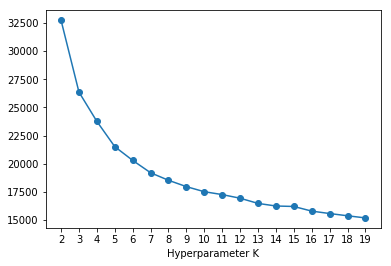

In [27]:
inertias =[]
from sklearn.cluster import KMeans

#define kmean related actions
def kmeans_function(n, data):
    model = KMeans(n_clusters=n)
    
    fit_data=model.fit_predict(data)
    
    inertias.append(model.inertia_)
    return fit_data
    
#loop between & including 2 and 10    
ks=range(2,20)
for k in ks:
    kmeans_function(k,X_train)

plt.plot(ks,inertias,'-o')
plt.xticks(ks)
plt.xlabel('Hyperparameter K')
plt.show()

### Elbow has a range between 3 and 5

# K-Mean Model w. PCA Dimensionality Reduction

After trying K of 3, 4 and 5, I have decided 3 has generated the cleanest clusters. 

In [28]:
k=3
model = PCA(n_components=2)
pca_feature = model.fit_transform(X_train)
kmeans_labels = kmeans_function(k,pca_feature)
summary_df = pd.DataFrame({'start station name' : X_train_nonNorm.index,'Label':kmeans_labels,'PCA x':pca_feature[:,0],'PCA y':pca_feature[:,1],'train_data':1})
summary_df.head()

,Label,PCA x,PCA y,start station name,train_data
0,1,9.433685,-2.162748,Canal St & Rutgers St,1
1,2,-3.942197,-2.609678,Graham Ave & Withers St,1
2,1,15.275508,-3.006166,1 Ave & E 16 St,1
3,2,-2.603605,-0.960029,Carroll St & Bond St,1
4,0,0.244693,4.403090,E 91 St & 2 Ave,1


## Visualizing the clusters. Since we are using PCA 2, this is easy to show.

Text(0.5,1,'PCA Cluster')

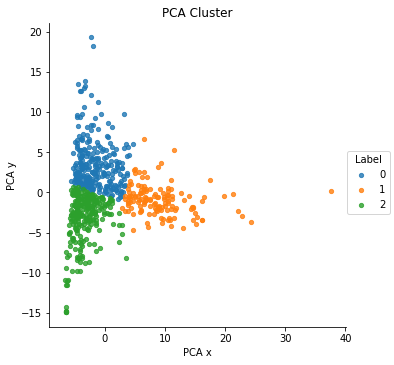

In [29]:
sns.lmplot(x='PCA x', y='PCA y', hue='Label', data=summary_df , fit_reg=False, size=5,scatter_kws={'s':18})
plt.title('PCA Cluster')
plt.show()


In [30]:
labels, counts = np.unique(kmeans_labels[kmeans_labels>=0], return_counts=True)
print (labels, counts)

[0 1 2] [269 136 250]


# Analysis of clustering results

In [31]:
#add the cluster labeling to the data file
merged_file_cleaned = pd.merge(merged_file_cleaned,summary_df,on='start station name')

Distance - Cluster split of data between weekday/weekend and Afternoon/Morning/Night

In [32]:
train_data = merged_file_cleaned[merged_file_cleaned.train_data==1]
#train_data.pivot_table(index=['Label'],aggfunc={'count', 'mean'},columns = 'Day_Segment',values='distance')
x=train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Weekend_Vs_Weekday','Day_Segment'],values='distance')
x.index.names = ['Cluster']
x.rename(index={0: 'Blue', 1: 'Red', 2: 'Green'})

Weekend_Vs_Weekday   Weekday                     Weekend                  
Day_Segment        Afternoon  Morning    Night Afternoon  Morning    Night
Cluster                                                                   
Blue                1.889595 2.121895 1.696010  1.838343 1.791213 1.704150
Red                 1.561193 1.587237 1.532442  1.540545 1.459975 1.513919
Green               1.289953 1.444376 1.221217  1.359176 1.371886 1.261616

Count - Cluster split of data between weekday/weekend and Afternoon/Morning/Night

In [33]:
y=train_data.pivot_table(index=['Label'],aggfunc='count',columns = ['Weekend_Vs_Weekday','Day_Segment'],values='distance')
y.index.names = ['Cluster']
y.rename(index={0: 'Blue', 1: 'Red', 2: 'Green'})

Weekend_Vs_Weekday   Weekday                  Weekend              
Day_Segment        Afternoon Morning  Night Afternoon Morning Night
Cluster                                                            
Blue                  142434   69998  14918     19502    5234  2108
Red                   283906  130471  36341     32584    7813  4932
Green                  80903   42600  13047     11851    3066  1804

Tripduration - Cluster split of data between weekday/weekend and Afternoon/Morning/
This has strong correlation with distance but we can still see some deviation

In [34]:

y=train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Weekend_Vs_Weekday','Day_Segment'],values='tripduration')
y.index.names = ['Cluster']
y.rename(index={0: 'Blue', 1: 'Red', 2: 'Green'})
#train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Day_Segment','gender'],values='distance') #0 unknown 1 male 2 female
#train_data.pivot_table(index=['Label'],aggfunc='mean',columns = 'Day_Of_Month',values='distance')
#train_data.pivot_table(index=['Label'],aggfunc={'count', 'mean'},columns = ['usertype','gender'],values='distance')

Weekend_Vs_Weekday     Weekday                            Weekend                        
Day_Segment          Afternoon    Morning       Night   Afternoon     Morning       Night
Cluster                                                                                  
Blue               1105.374482 816.846181 1348.749162 1028.723208  788.958540  774.002846
Red                 824.670472 652.512512  841.245645  806.219740  692.992960  698.279197
Green               883.854146 853.376244 2031.047750  825.321914 1074.222440 1667.555987

 Distance/Count - some analysis on Gender and usertype 0-unknown, 1-male, 2-female
 
 

In [35]:

train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Day_Segment','gender'],values='distance')
train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Day_Segment','usertype'],values='distance')
train_data.pivot_table(index=['Label'],aggfunc='count',columns = ['Day_Segment','gender'],values='distance')
train_data.pivot_table(index=['Label'],aggfunc='count',columns = ['usertype'],values='distance')


Day_Segment Afternoon                    Morning                      Night                  
gender              0        1        2        0        1        2        0        1        2
Label                                                                                        
0            1.993914 1.855453 1.918920 2.121427 2.102262 2.084949 1.903895 1.702021 1.621711
1            1.757805 1.534014 1.588561 1.667174 1.569997 1.603497 1.686385 1.500209 1.627297
2            1.485510 1.272978 1.316506 1.562473 1.426240 1.455549 1.489583 1.213043 1.220670

Day_Segment Afternoon             Morning               Night           
usertype     Customer Subscriber Customer Subscriber Customer Subscriber
Label                                                                   
0            2.053573   1.863065 2.258945   2.093628 2.053665   1.681475
1            1.841325   1.540249 1.852165   1.573580 1.734619   1.521152
2            1.634360   1.277252 1.972749   1.429334 1.618932   1.214524

Day_Segment Afternoon                Morning                Night             
gender              0       1      2       0       1      2     0      1     2
Label                                                                         
0               16421  109974  35541    3114   54013  18105   826  13063  3137
1               19509  231658  65323    4005  104411  29868  1861  32389  7023
2                6736   63889  22129    1937   32059  11670   624  11382  2845

usertype,Customer,Subscriber
Label,,
0,20410,233784
1,24747,471300
2,6877,146394



Additional Analysis on Birthyear and Temperature

In [36]:
train_data.pivot_table(index=['Label'],aggfunc='mean',values='birth year')
train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Weekend_Vs_Weekday','Day_Segment'],values='HourlyDewPointTemperature')
#train_data.pivot_table(index=['Label'],aggfunc='mean',columns = ['Weekend_Vs_Weekday','Day_Segment'],values='HourlyPrecipitation')

,birth year
Label,
0,1977.605774
1,1978.121067
2,1978.718127


Weekend_Vs_Weekday   Weekday                       Weekend                    
Day_Segment        Afternoon   Morning     Night Afternoon   Morning     Night
Label                                                                         
0                  25.887520 27.028972 28.093578 16.693160 19.225831 18.136622
1                  26.231450 27.110461 27.925016 16.707679 19.344170 18.329075
2                  25.872551 27.254460 27.998160 16.637077 19.230920 18.524390

# Plot On Google Map

In [37]:
google_map_data = merged_file_cleaned[merged_file_cleaned['train_data']==1][['start station name','start station latitude','start station longitude','Label']]
google_map_data.sort_values("start station name", inplace = True) 
google_map_data.drop_duplicates(keep = 'last', inplace = True)

In [38]:
google_map_data.head()

,start station name,start station latitude,start station longitude,Label
646973,1 Ave & E 110 St,40.792327,-73.938300,0
209629,1 Ave & E 16 St,40.732219,-73.981656,1
594990,1 Ave & E 18 St,40.733812,-73.980544,1
253056,1 Ave & E 30 St,40.741444,-73.975361,1
144306,1 Ave & E 44 St,40.750020,-73.969053,0


In [39]:
# Place map
gmap = gmplot.GoogleMapPlotter(40.7265, -73.9815, 13)
apikey1 = "my key"
gmap.apikey = apikey1
# Polygon
#golden_gate_park_lats, golden_gate_park_lons = zip(*[
##    (37.771269, -122.511015),
#    ])
#gmap.plot(golden_gate_park_lats, golden_gate_park_lons, 'cornflowerblue', edge_width=10)

# Scatter points
lat0 = google_map_data[google_map_data['Label']==0]['start station latitude']
lon0 = google_map_data[google_map_data['Label']==0]['start station longitude']
lat1 = google_map_data[google_map_data['Label']==1]['start station latitude']
lon1 = google_map_data[google_map_data['Label']==1]['start station longitude']
lat2 = google_map_data[google_map_data['Label']==2]['start station latitude']
lon2 = google_map_data[google_map_data['Label']==2]['start station longitude']
gmap.scatter(lat0, lon0, 'blue', size=40, marker=False)
gmap.scatter(lat1, lon1, 'red', size=40, marker=False)
gmap.scatter(lat2, lon2, 'green', size=40, marker=False)
# Marker


# Draw
gmap.draw( "C:/Users/Charles/Desktop/Data Science/Capstone Project 1/map13.html" ) 

# Graphs

Visualize cluster count in graph form

Text(0,0.5,'Count')

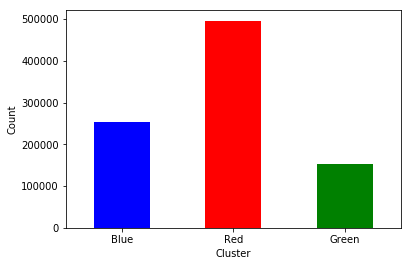

In [40]:
from itertools import cycle, islice
count_data = train_data.pivot_table(index=['Label'],aggfunc='count',values='distance')
count_data = count_data.rename(columns={"distance": "count"})
count_data.index.names = ['Cluster']
count_data = count_data.rename(index={0: 'Blue', 1: 'Red', 2: 'Green'})
my_colors = list(islice(cycle(['b', 'r', 'g']), None, len(count_data)))
graph = count_data['count'].plot(kind='bar', rot=0, stacked=True, color =['b','r','g'])
graph.set_ylabel("Count")